In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pickle
import scipy
from scipy.interpolate import interp1d
import skimage
from skimage import io, exposure, filters

from numpy.fft import fftshift, fft2, ifft2, fft, ifft
from numpy import real
from numpy import conj

%matplotlib notebook


In [2]:
all_data = {}

Set the directory for where the data is below.

In [3]:
drive_letter = "Y"
data_dir = drive_letter+":\\Dennis Terwilliger\\Data\\2021-08-10\\01_Flow_sweep_31Deg_20x\\"
sub_dir_number = 5
sub_dir = "Flow_sweep_31Deg_20x_%i" % sub_dir_number
data_file = "\\" + sub_dir + "_MMStack_Default.ome.tif"
full_path = data_dir+sub_dir+data_file

#Enter the correct pixel size below: 
pixel_size = 0.501

experiment_number = 1
shear_rate = 2.46

dictionary_entry = '2021-08-10 - 0%i - 0%i - %.2fHz' % (experiment_number, sub_dir_number, shear_rate)
print(dictionary_entry)

all_data[dictionary_entry] = {}
all_data[dictionary_entry]['path'] = full_path
all_data[dictionary_entry]['shear rate'] = shear_rate

2021-08-10 - 01 - 05 - 2.46Hz


In [4]:
images = skimage.io.imread(data_dir+sub_dir+data_file)
print("Number of frames in %s: %s" % (data_file, images.shape[0]))
print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

##Creating background
mean_image = images.mean(axis=0)
background = filters.gaussian(mean_image, sigma=120)

Number of frames in \Flow_sweep_31Deg_20x_5_MMStack_Default.ome.tif: 1000
Dimensions of an image is 492 by 656 pixels.


<IPython.core.display.Javascript object>


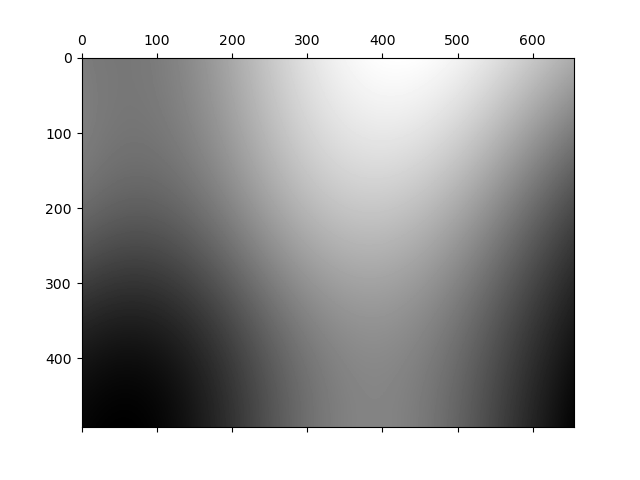

In [5]:
plt.figure()
plt.matshow(background, fignum=0, cmap='gray')

Below we define the function for 2D and 1D image autocorrelation

In [6]:
def autocorrelation_2D(image):
    data = image-image.mean() 
    data = data / data.std()
    
    temp = real(fftshift(ifft2(fft2(data)*conj(fft2(data)))))
    temp = temp / (data.shape[0]*data.shape[1])
    
    return temp

def autocorrelation_1D(image, ax):
    # This function computes a 1D correlation
    # of a 2D image. 
    # Input parameters:
    #    image -- a 2D numpy array
    #    ax -- the axis to perform the autocorrelation
    #
    # Note about which axes to use:
    #   for ax = 0: this will correlate things along the vertical direction when displayed using matshow
    #   for ax = 1: this will correlate along the horizontal direction when displayed using matshow
    
    means = image.mean(axis=ax)
    temp = np.tile(means, (image.shape[ax], 1))
    if ax==0:
        data = image - temp
    elif ax==1:
        data = image - temp.transpose()
    else:
        print("ax must be 0 or 1")
        return 0
    
    std_devs = data.std(axis=ax)
    #print("shape of std_devs: ", std_devs.shape) #for debugging purposes
    temp = np.tile(std_devs, (image.shape[ax],1))
    if ax==0:
        data = data / temp
    elif ax==1:
        data = data / temp.transpose()
        
    temp = fftshift(ifft(fft(data,axis=ax)*conj(fft(data,axis=ax)),axis=ax),axes=ax)
    temp = real(temp) / data.shape[ax]
       
    if ax==0:
        corr = temp.sum(axis=1)/temp.shape[1]
        return corr[int(temp.shape[0]/2):]
    elif ax==1:
        corr = temp.sum(axis=0)/temp.shape[0]
        return corr[int(temp.shape[1]/2):]
    
def find_where_corr_at_half(corr, val=0.5):
    # This function will actually only find where the correlation function goes to 0.5
    # (which, if properly normalized, means that it dropped 50%) if the "val" is set
    # to 0.5 which is the default. However, you can change that to another value like
    # 0.2 or 1/e or something else. 
    f = interp1d(np.arange(0,len(corr)), corr, kind='linear', fill_value="extrapolate") #create interpolation function
    new_x = np.linspace(0, len(corr), 10*len(corr))  #new x-axis that is 10 times more sampled
    eval_at_new_x = f(new_x) #evaluate the interpolated function over the new range of x-values
    min_index = np.argmin(abs(eval_at_new_x-val)) #find where that is closest to "val" 
    return new_x[min_index]

(1000, 492, 656)
(492, 656)


<IPython.core.display.Javascript object>


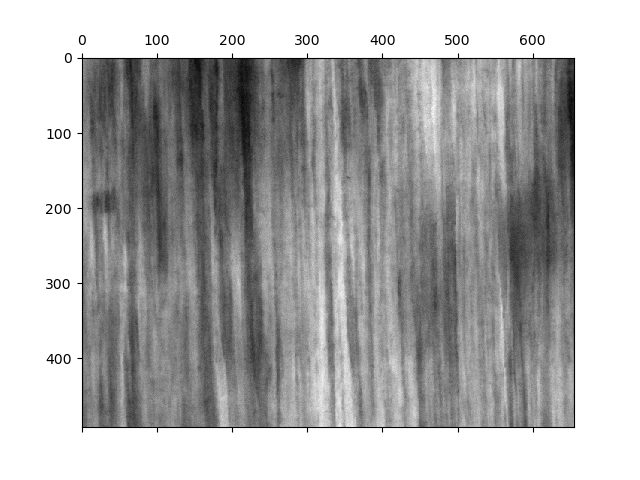

<IPython.core.display.Javascript object>


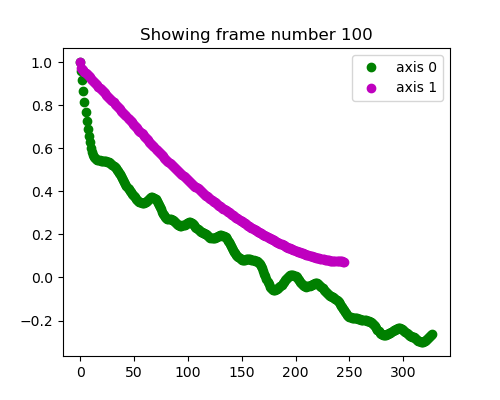

Where the correlation goes to 70% for axis 0:  6.702043305885941
Where the correlation goes to 70% for axis 1:  51.52094347295649


In [7]:
##################################
# Enter frame number to analyze  #
##################################
frame_to_show = 100


im = images[frame_to_show]
print(images.shape)
print(im.shape)

#Creates figure and shows region to analyze
filtered_image = 1.0 * im - background
plt.figure()
plt.matshow(filtered_image, fignum=0, cmap='gray') #shows image

corr2d = autocorrelation_2D(filtered_image)
plt.figure(figsize=(5,4))
acorr_0 = autocorrelation_1D(filtered_image,0)
acorr_1 = autocorrelation_1D(filtered_image,1)
#plt.plot(acorr_0,'bo',label='axis 0')
#plt.plot(acorr_1,'ro',label='axis 1')
acorr0_from2d = corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
acorr1_from2d = corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
plt.plot(acorr0_from2d, 'go', label='axis 0')
plt.plot(acorr1_from2d, 'mo', label='axis 1')
print("Where the correlation goes to 70% for axis 0: ", find_where_corr_at_half(acorr0_from2d, val=0.7))
print("Where the correlation goes to 70% for axis 1: ", find_where_corr_at_half(acorr1_from2d, val=0.7))
plt.title("Showing frame number %i" % frame_to_show)
plt.legend(loc=0)

#Create figure for 2D autocorrelation
#plt.figure()
#plt.matshow(corr2d, fignum=0, cmap='gray')

In [8]:
def autocorr_decay_value(images, background, framenum, decay_fraction=0.7):
    filtered_image = 1.0 * images[framenum] - background
    corr2d = autocorrelation_2D(filtered_image)

    acorr0_from2d = corr2d[int(filtered_image.shape[0]/2),int(filtered_image.shape[1]/2):]
    acorr1_from2d = corr2d[int(filtered_image.shape[0]/2):,int(filtered_image.shape[1]/2)]
    where_autocorr_decay_0 = find_where_corr_at_half(acorr0_from2d, val=decay_fraction)
    where_autocorr_decay_1 = find_where_corr_at_half(acorr1_from2d, val=decay_fraction)
    return (where_autocorr_decay_0, where_autocorr_decay_1)

In [11]:
print(im.shape)

(492, 656)


In [13]:
all_horizontal_lengthscales = np.zeros((images.shape[0]))
all_vertical_lengthscales = np.zeros_like(all_horizontal_lengthscales)
for i in range(0,images.shape[0]):
    all_horizontal_lengthscales[i], all_vertical_lengthscales[i] = autocorr_decay_value(images, background, i, decay_fraction=0.7)
    
all_data[dictionary_entry]['all_horizontal_lengthscales'] = all_horizontal_lengthscales
all_data[dictionary_entry]['all_vertical_lengthscales'] = all_vertical_lengthscales
all_data[dictionary_entry]['mean_horizontal_lengthscale'] = all_horizontal_lengthscales.mean()
all_data[dictionary_entry]['mean_vertical_lengthscale'] = all_vertical_lengthscales.mean()

<IPython.core.display.Javascript object>


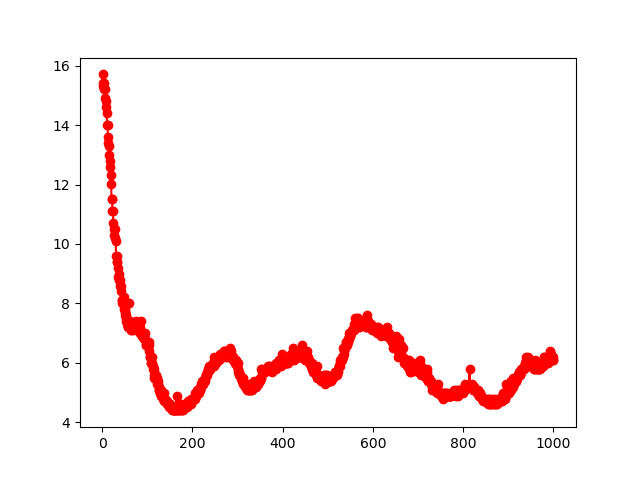

<IPython.core.display.Javascript object>


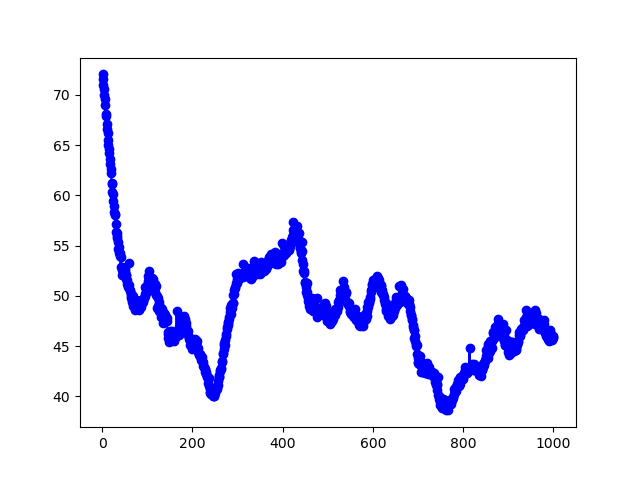

In [14]:
frames = np.arange(1,images.shape[0]+1)
plt.figure()
plt.plot(frames,all_horizontal_lengthscales,'-ro')
plt.figure()
plt.plot(frames,all_vertical_lengthscales,'-bo')

<IPython.core.display.Javascript object>


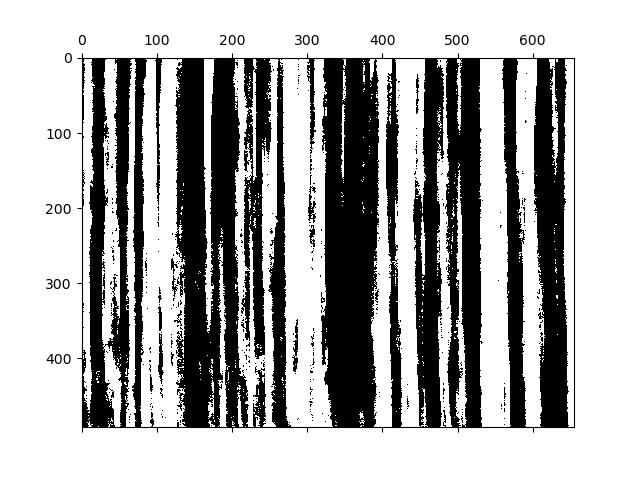

<IPython.core.display.Javascript object>


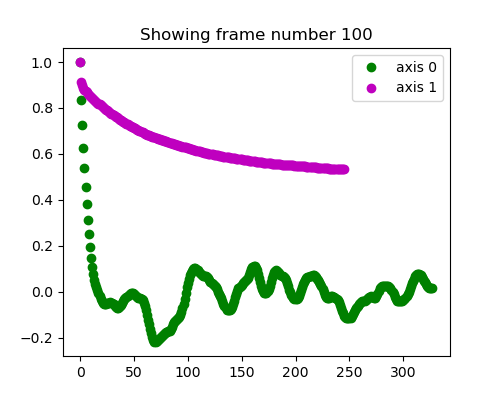

Where the correlation goes to 10% for axis 0:  107.93290637389448
Where the correlation goes to 10% for axis 1:  243.9991866612444


<ipython-input-19-0d19a49f7c3d>:35: RuntimeWarning: invalid value encountered in true_divide
  data = data / temp


In [61]:
#Convert image to binary (black and white)
block_size = 251
local_threshold = filters.threshold_local(filtered_image, block_size, offset=10)
binary_image = filtered_image > local_threshold

#Creates figure and shows region to analyze
plt.figure()
plt.matshow(binary_image, fignum=0, cmap='gray') #shows image

corr2d = autocorrelation_2D(binary_image)
plt.figure(figsize=(5,4))
acorr_0 = autocorrelation_1D(binary_image,0)
acorr_1 = autocorrelation_1D(binary_image,1)
#plt.plot(acorr_0,'bo',label='axis 0')
#plt.plot(acorr_1,'ro',label='axis 1')
acorr0_from2d = corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
acorr1_from2d = corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
plt.plot(acorr0_from2d, 'go', label='axis 0')
plt.plot(acorr1_from2d, 'mo', label='axis 1')
print("Where the correlation goes to 10% for axis 0: ", find_where_corr_at_half(acorr0_from2d, val=0.1))
print("Where the correlation goes to 10% for axis 1: ", find_where_corr_at_half(acorr1_from2d, val=0.1))
plt.title("Showing frame number %i" % frame_to_show)
plt.legend(loc=0)